# Data exploration

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_path = os.path.join('..', 'src', 'data','train.json')

# opening and reading the json file
f = open(data_path)
data = json.load(f)
 
# iterating through the json list
for i in data[:10]:
    print(i)
 
# closing the file
f.close()


{'document': 7, 'full_text': "Design Thinking for innovation reflexion-Avril 2021-Nathalie Sylla\n\nChallenge & selection\n\nThe tool I use to help all stakeholders finding their way through the complexity of a project is the  mind map.\n\nWhat exactly is a mind map? According to the definition of Buzan T. and Buzan B. (1999, Dessine-moi  l'intelligence. Paris: Les Éditions d'Organisation.), the mind map (or heuristic diagram) is a graphic  representation technique that follows the natural functioning of the mind and allows the brain's  potential to be released. Cf Annex1\n\nThis tool has many advantages:\n\n•  It is accessible to all and does not require significant material investment and can be done  quickly\n\n•  It is scalable\n\n•  It allows categorization and linking of information\n\n•  It can be applied to any type of situation: notetaking, problem solving, analysis, creation of  new ideas\n\n•  It is suitable for all people and is easy to learn\n\n•  It is fun and encourages 

In [3]:
print("Number of samples: ", len(data))

Number of samples:  6807


In [4]:
print(f"data fields: {data[0].keys()}")

data fields: dict_keys(['document', 'full_text', 'tokens', 'trailing_whitespace', 'labels'])


In [5]:
data_df = pd.DataFrame(data)

In [6]:
data_df['length'] = data_df['tokens'].apply(len)
avg_text_length = data_df['length'].mean()
longest_text_length = data_df['length'].max()
longest_text = data_df['full_text'][data_df['length'].idxmax()]
shortest_text_length = data_df['length'].min()
shortest_text = data_df['full_text'][data_df['length'].idxmin()]
print(f"Longest text - length: {longest_text_length}")
print(f"Shortest text: {shortest_text_length}")
print(f"Average text length (words): {avg_text_length:.2f}")

Longest text - length: 3298
Shortest text: 69
Average text length (words): 733.44


In [7]:
print(f"longest text: \n{longest_text}")

longest text: 
Re-Engaging  Students:  A  Learning  Launch  Experiment

Salman Fong,  June  27  2020

1. Challenge

At   an   EdTech   company   that   I   worked   at,   we   were   undergoing   a   massive   digital   transformation   program.   Our   team   was   tasked   with   finding   innovative   solutions   that   we   can   bring   to   the   market   quickly   to   broaden   our   offering   by   utilizing   our   existing   content.   The   company   was   a   traditional   publishing   house   catering   textbooks   to   a   large   number   of   schools   &   universities.   It   was   not   easy   to   change   the   existing   business   processes.   The   backend   content   creation,   organization   and   data-management   was   a   time-consuming   process.   But   it  provided   the   high   quality   content   that   the   market   had   come   to   expect   of   the   company.   We   cannot   compromise   on   the   quality   for   sure,   but   we   need   to   

In [8]:
print(f"shortest text: \n{shortest_text}")

shortest text: 
Think Twice and Make a Wise

Concept Mapping:

I  have choosen concept mapping to illustrate and easy understanding for BDS students

. Here i have did the concept mapping based upon the branches of dentistry, so that they can  easily identify what are the clinicals and non-clinicals subjects they are going to face

Branches of Dentistry

Endodontics




Checking if our suspicion that PII appears either at the beginning or at the end is true

In [9]:
[(i,label) for i, label in enumerate(data_df['labels'][data_df['length'].idxmax()]) if label != 'O']

[(15, 'B-NAME_STUDENT'),
 (16, 'I-NAME_STUDENT'),
 (3288, 'B-NAME_STUDENT'),
 (3289, 'I-NAME_STUDENT')]

As we can see above, the name of the student appears at the beginning and at the end. Now let's check how it is for the whole dataset

In [10]:
data_df['labeled_tokens'] = data_df.apply(lambda x: [x['tokens'][i] for i, label in enumerate(x['labels']) if label != 'O'], axis=1)
data_df['labeled_indexes'] = data_df.apply(lambda x: [i for i, label in enumerate(x['labels']) if label != 'O'], axis=1)
data_df['labeled_indexes'].head()

0    [9, 10, 482, 483, 741, 742]
1               [0, 1, 464, 465]
2                         [4, 5]
3                         [5, 6]
4                       [12, 13]
Name: labeled_indexes, dtype: object

In [11]:
#a column that describes in which part of the text the labeled tokens are 
def label_distribution(row, nb_parts = 4):
    """ 
    input: 
        - row: row of a dataframe
        - nb_parts: int
    output:
        - list of length nb_parts with, with a True if there is a label in that part and false otherwise
    """
    indices = row['labeled_indexes']
    text_length = len(row['tokens'])
    indices = [id/text_length for id in indices]
    # checking if the labeled indexes are in the first part, second part, etc
    return [any((n)/nb_parts <= id <(n+1)/nb_parts for id in indices) for n in range(nb_parts)]

nb_parts = 8
data_df["label_distribution"] = data_df.apply(lambda x: label_distribution(x, nb_parts),axis=1)
data_df["text_length"] = data_df.apply(lambda x: len(x['tokens']),axis=1)
print(data_df[['labeled_indexes','label_distribution','text_length']].head())

               labeled_indexes  \
0  [9, 10, 482, 483, 741, 742]   
1             [0, 1, 464, 465]   
2                       [4, 5]   
3                       [5, 6]   
4                     [12, 13]   

                                  label_distribution  text_length  
0  [True, False, False, False, False, True, False...          753  
1  [True, False, False, False, False, False, True...          563  
2  [True, False, False, False, False, False, Fals...          729  
3  [True, False, False, False, False, False, Fals...         1071  
4  [True, False, False, False, False, False, Fals...         1927  


## Location of labels
The graph below show how many of the PII labeled tokens appear in each quantile of the texts.

[763  25  42  65  74  75  57 171]


<BarContainer object of 8 artists>

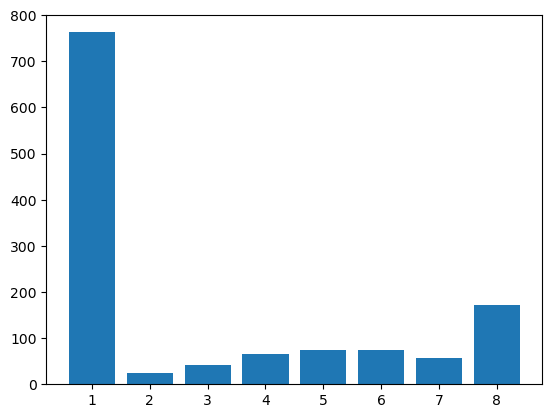

In [12]:
#plotting the distribution of the labels
label_distribution = np.array(data_df['label_distribution'].tolist())
label_distribution = label_distribution.sum(axis=0)
print(label_distribution)
plt.bar(range(1,nb_parts+1), label_distribution)

As seen in the graph above, most of the PII is at the beginning of the document

## Distribution of labels

In [13]:
all_labels = set([label for sublist in data_df['labels'] for label in sublist])
all_labels

{'B-EMAIL',
 'B-ID_NUM',
 'B-NAME_STUDENT',
 'B-PHONE_NUM',
 'B-STREET_ADDRESS',
 'B-URL_PERSONAL',
 'B-USERNAME',
 'I-ID_NUM',
 'I-NAME_STUDENT',
 'I-PHONE_NUM',
 'I-STREET_ADDRESS',
 'I-URL_PERSONAL',
 'O'}

In [14]:
label_counts = (data_df['labels'].apply(pd.Series).stack().value_counts())
label_counts = label_counts[label_counts.index != 'O']
label_counts = label_counts.sort_values(ascending=False)
label_counts_no_i = label_counts.drop(labels=[label for label in label_counts.index if 'I-' in label])
label_counts_no_i

B-NAME_STUDENT      1365
B-URL_PERSONAL       110
B-ID_NUM              78
B-EMAIL               39
B-USERNAME             6
B-PHONE_NUM            6
B-STREET_ADDRESS       2
Name: count, dtype: int64

In [15]:
[label for label in label_counts.index if not 'I-' in label]

['B-NAME_STUDENT',
 'B-URL_PERSONAL',
 'B-ID_NUM',
 'B-EMAIL',
 'B-USERNAME',
 'B-PHONE_NUM',
 'B-STREET_ADDRESS']

### All labels

<BarContainer object of 12 artists>

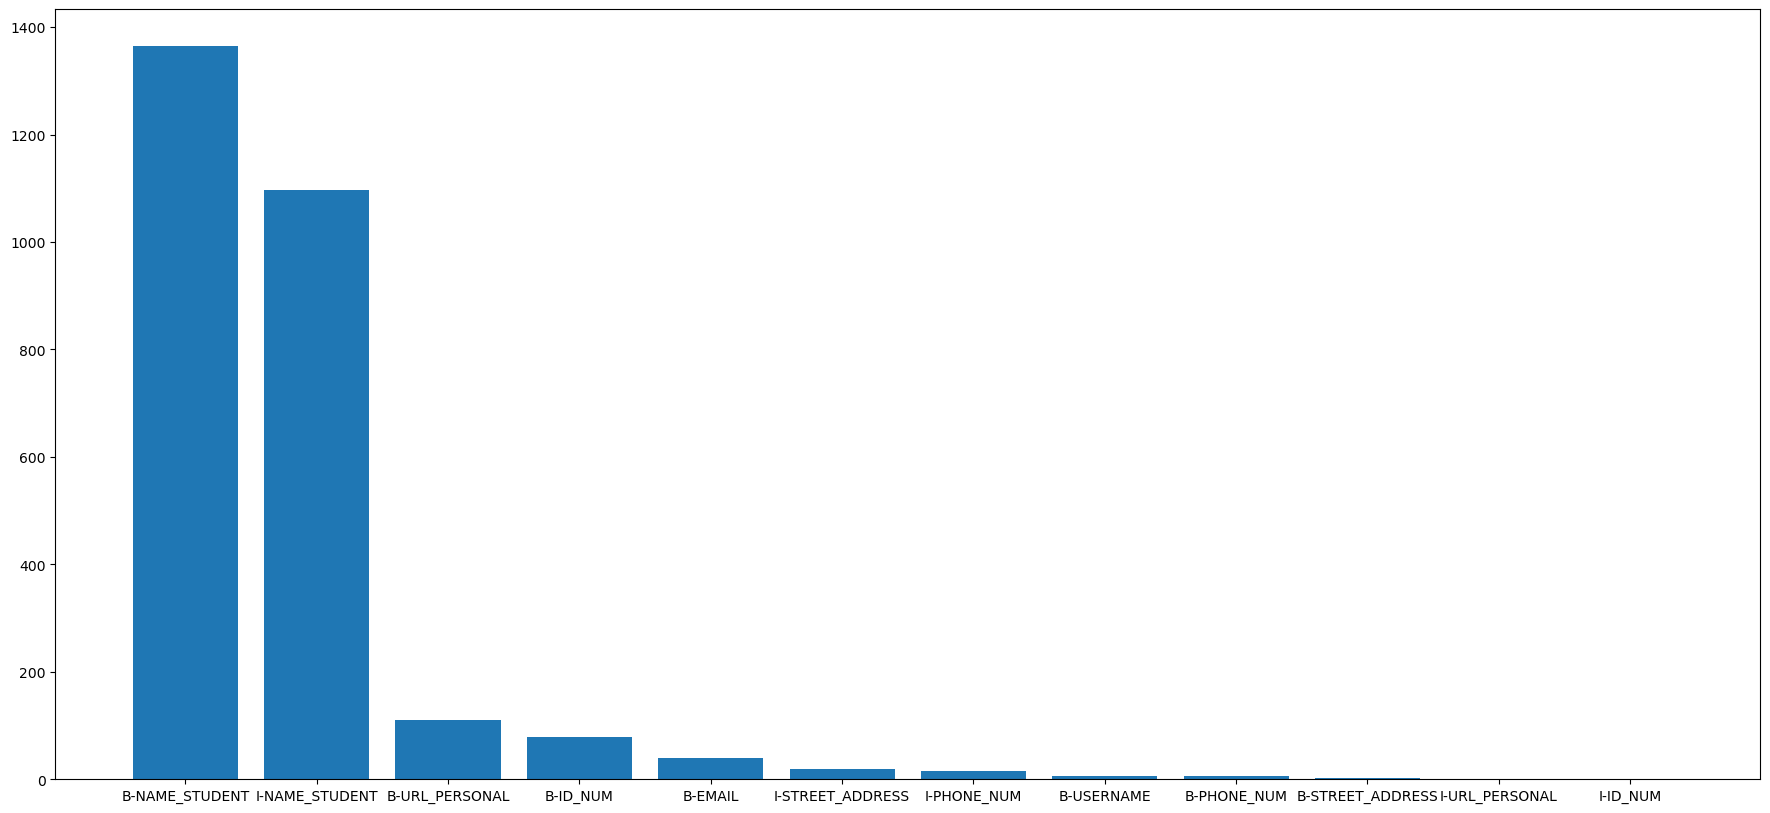

In [16]:
plt.figure(figsize=(22,10))
plt.bar(label_counts.index, label_counts)

### Only the beginning of the labels

<BarContainer object of 7 artists>

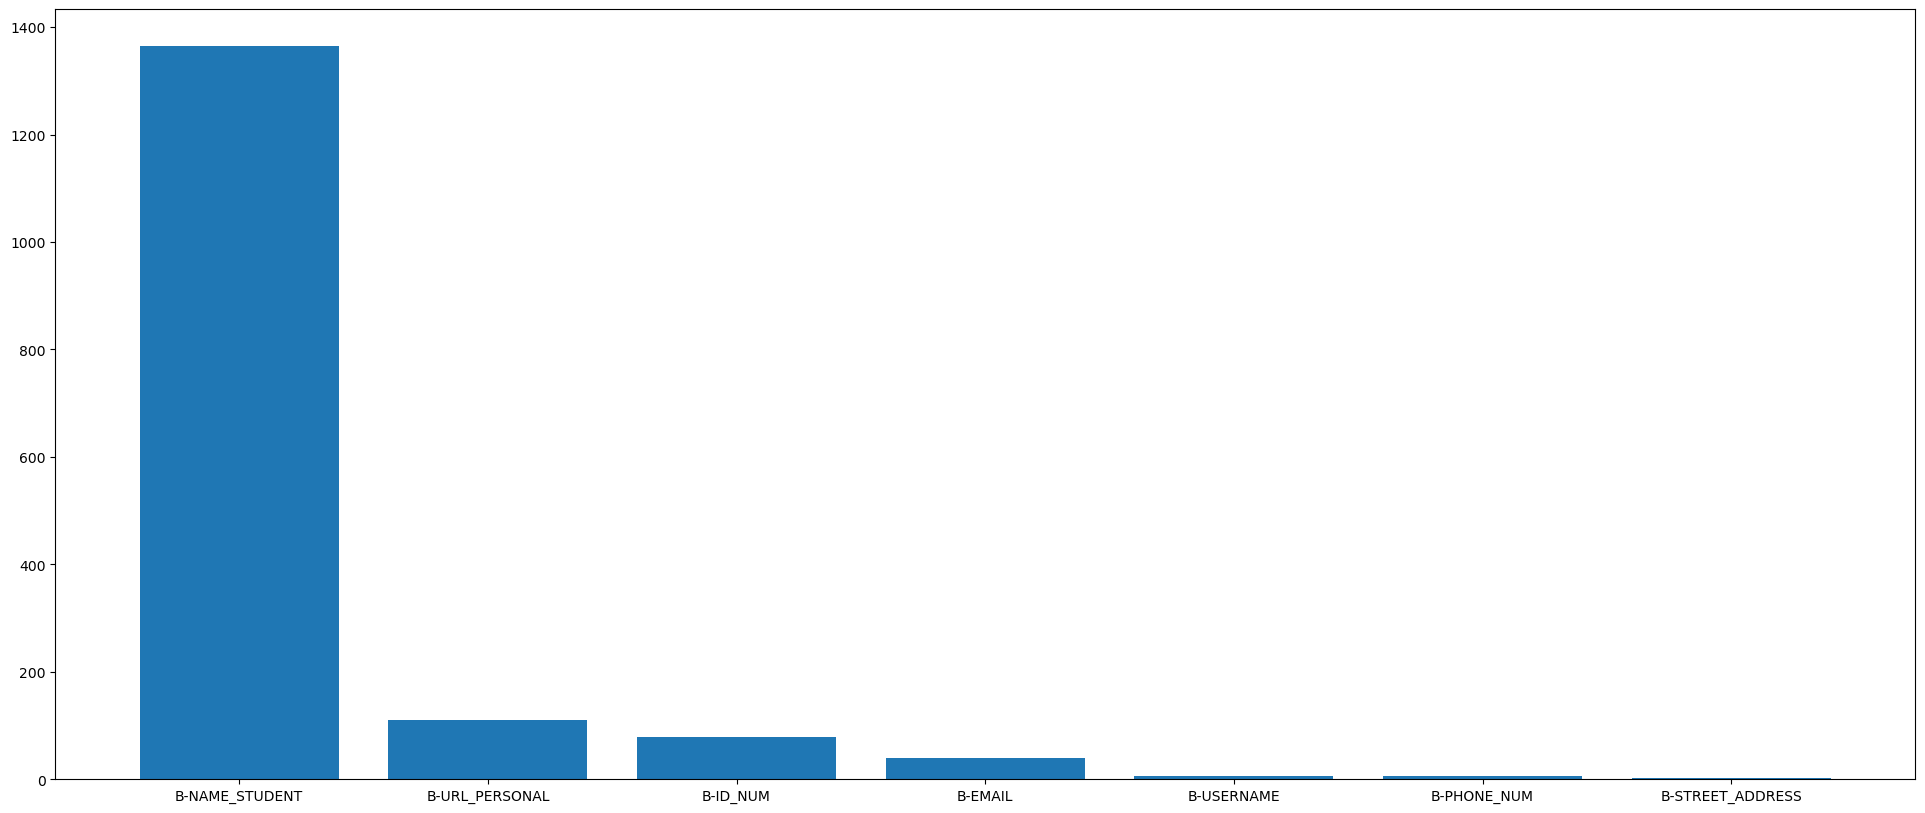

In [17]:
plt.figure(figsize=(24,10))
plt.bar(label_counts_no_i.index, label_counts_no_i)